#           **AhmedSamyAhmed_IndustryClassificationTask**

<hr>


# Here is the given Task from iNetworks:
- [iNetworks Task](https://drive.google.com/file/d/1tZOND2BCcRmFSiQJVOgPE1TZtDnYbvoO/view?fbclid=IwAR1UE9iIxG1pGjiWGLJze-vKhOaInydHIju6SolAIHv9qamlQ6LP5NUf5Yg)

# Introduction

At first , In this task i was given a dataset from 2 cols & 8587 rows , And i was asked to : 
- Show the Data set .
- Solve target imbalancing problem .
- Create a Classifier model that classify these data into 4 main -Industry- classes  (Choose your own classifier , Not restricted).
- Use Flask API to deploy the RESTful API service.

**Note :** All resources i depend on it in this task is at the last of this Notebook .

And now , let's start ...

# Preparations
For the preparations lets first import the necessary libraries and load the files needed for our work.

**Note :** Colab can't save files for a long time ,so if the Dataset file was not found the link below will be enough.

- ## Dataset: [Dataset Link ](https://drive.google.com/file/d/1W_MO19MlDDUn0qCfxEaVxGKKlKHsFFly/view)



In [64]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt 
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score , classification_report ,r2_score

Jobs = pd.read_csv('Job titles and industries.csv', encoding = "ISO-8859-1", usecols=[0,1])

print(Jobs.shape)
Jobs.head()

(8586, 2)


,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


## From this output you can see that the data is from just two categorical columns and we will need to classify it , which means we need to pre-process this dataset before applying the model to classify this dataset .

In [65]:
# Rename -job title- column for better handeling
Jobs.rename(columns={"job title": "job_title"}, inplace=True)

# Dataset is imbalanced
In the cell below , you can see by visualization or even numbers that data in not balanced , so we have to handle this issue.

**Aknowledgement** When i used the dataset without being balanced , the model made overfitting ,But after data have been made to be balanced specifically using over sampling , model got give better performance . 

IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: industry, dtype: int64


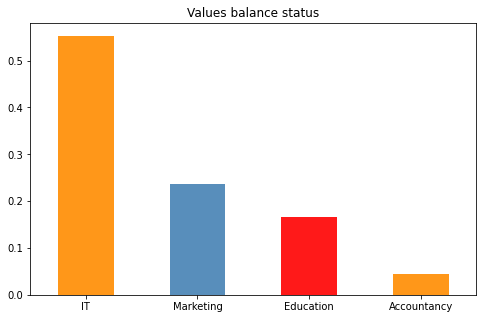

In [66]:
print(Jobs['industry'].value_counts())

# Checking the nature of data set: balanced or imbalanced?
fig = plt.figure(figsize = (8,5))
Jobs.industry.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue','red'], alpha = 0.9, rot=0)
plt.title('Values balance status')
plt.show()

# Data oversampling

in this step below i solved the imbalanced data problem using a famous way which's called oversampling , in this way we repeats rows of classes which is little to make all classes with the same number of rows (this Differentiates my model in next steps )

In [67]:
#x= df_train[Best_features]
y = Jobs[['industry']]
x = Jobs[['job_title']]
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy= {'Marketing': 4746 , 'Education' :4746 ,'Accountancy':4746 })
x, y = oversample.fit_resample(x, y)
y=pd.DataFrame(y)
y.columns=['y']
Jobs = pd.concat([pd.DataFrame(x) , y],axis=1)
Jobs.columns=['job_title','industry']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


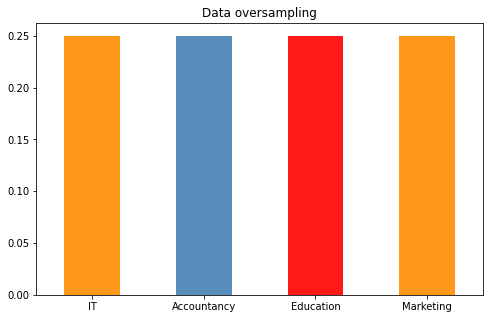

IT             4746
Accountancy    4746
Education      4746
Marketing      4746
Name: industry, dtype: int64


In [68]:

# Checking the nature of dataset: balanced or imbalanced?
fig = plt.figure(figsize = (8,5))
Jobs.industry.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue','red'], alpha = 0.9, rot=0)
plt.title('Data oversampling')
plt.show()
print(Jobs['industry'].value_counts())


### Above you can see the difference  between the two balancity . 

# Data Cleaning
### in a data like this , cleaning the dataset will be different from just fillna or drop_duplicates like we do in traditional datasets that we deal with , As we deal with a categorical data so in this step it'll be enought to remove punctuations and make all job titles in lower case for better knowing of each word as a stable pattern in modeling step. 



In [69]:
# After cleaning
Jobs['job_title'] = Jobs['job_title'].str.replace('\W', ' ') # Removes punctuation
Jobs['job_title'] = Jobs['job_title'].str.lower()
Jobs.head(5)

,job_title,industry
0,technical support and helpdesk supervisor co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


# pre-processing Step

in this step we **firstly** get each word in each column alone , **Secondly** we convert categorical job titles which is like separated words into numbers for better handling in the classifier model.

In [70]:
#create a dictionary contain each word in each column to be weighted in the next step
vocabulary = []
for job in Jobs['job_title']:
    for word in job:
        vocabulary.append(word)
vocabulary = list(set(vocabulary))

In [71]:
# in each job title row you give each word a weight of number of redundancy to be used in the model .
# this is because model can deal with categorical data so we convert it to numerical data.

word_counts_per_job = {unique_word: [0] * len(Jobs['job_title']) for unique_word in vocabulary}

for index, job in enumerate(Jobs['job_title']):
    for word in job:
        word_counts_per_job[word][index] += 1

word_counts = pd.DataFrame(word_counts_per_job)
word_counts.head()

,8,f,5,r,6,g,9,d,y,m,j,n,¼,3,ù,p,q,u,â,ø,2,l,e,i,c,s,t,4,w,x,,v,ã,7,z,o,1,0,h,k,a,b
0,1,0,0,4,1,1,0,3,2,0,0,4,0,0,0,4,0,4,0,0,0,3,4,4,3,6,3,1,0,0,11,1,0,0,0,4,0,2,2,1,4,1
1,0,0,0,3,0,1,0,0,0,0,0,4,0,0,0,2,0,1,0,0,0,1,5,3,2,2,2,0,0,0,3,0,0,0,0,2,0,0,1,0,1,0
2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,2,1,0,0,0,3,1,0,0,0,1,0,0,1,0,1,0
3,0,1,0,2,0,1,0,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,4,1,0,1,1,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,3,0,0,0,1,1,0,0,4,0,0,0,1,0,0,0,0,0,3,4,0,1,0,3,0,1,0,3,0,0,0,0,4,0,0,1,1,1,0


In [72]:
Jobs_clean = pd.concat([Jobs, word_counts], axis=1)
Jobs_clean.head(5)

,job_title,industry,8,f,5,r,6,g,9,d,y,m,j,n,¼,3,ù,p,q,u,â,ø,2,l,e,i,c,s,t,4,w,x,,v,ã,7,z,o,1,0,h,k,a,b
0,technical support and helpdesk supervisor co...,IT,1,0,0,4,1,1,0,3,2,0,0,4,0,0,0,4,0,4,0,0,0,3,4,4,3,6,3,1,0,0,11,1,0,0,0,4,0,2,2,1,4,1
1,senior technical support engineer,IT,0,0,0,3,0,1,0,0,0,0,0,4,0,0,0,2,0,1,0,0,0,1,5,3,2,2,2,0,0,0,3,0,0,0,0,2,0,0,1,0,1,0
2,head of it services,IT,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,2,1,0,0,0,3,1,0,0,0,1,0,0,1,0,1,0
3,js front end engineer,IT,0,1,0,2,0,1,0,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,4,1,0,1,1,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0
4,network and telephony controller,IT,0,0,0,3,0,0,0,1,1,0,0,4,0,0,0,1,0,0,0,0,0,3,4,0,1,0,3,0,1,0,3,0,0,0,0,4,0,0,1,1,1,0


# Classifier Model

And finally we got to the modeling step in this step you are free to choose any model (naive Bayes , Decision tree , and so on...) But now i'll use (XGBoost) 
- XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
- The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost.
- Three main forms of gradient boosting are supported:

1. Gradient Boosting algorithm also called gradient boosting machine including the learning rate.
2. Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
3. Regularized Gradient Boosting with both L1 and L2 regularization.

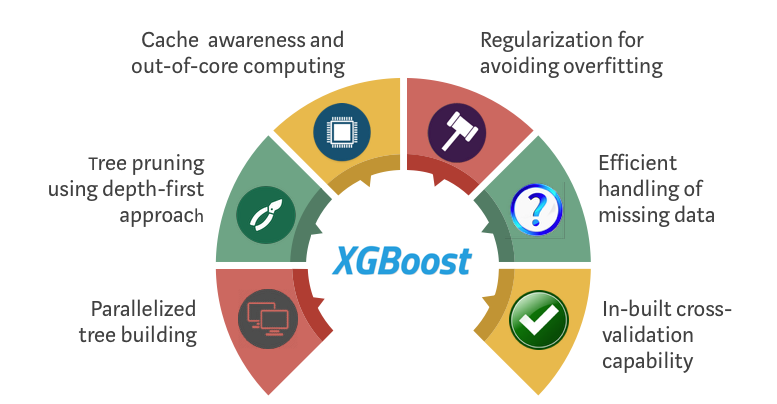

In [73]:
#we want to get x & y to insert as inputs for train_test_split 
y = Jobs_clean[['industry']]
X = Jobs_clean.drop(columns = ['job_title','industry'],axis=1)

#here we get the dataset to be splited to deploy the model on
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#this is the main function which contain the model and the whole training and testing process
def predict():
    # hyper parameter tuning step in this step you choose you best parameters which fit your model
    clf = xgb.XGBClassifier(booster='gbtree', learning_rate=0.300000012, max_depth=6, n_estimators=100, n_jobs=1, random_state=0)
    # Training the model 
    clf.fit(X_train, y_train)

    # predicting trained data
    pred_train=clf.predict(X_train)

    # predicting testing data 
    pred_test=pd.DataFrame(clf.predict(X_test))

    print('--------------------------------------------------------------------------------------------')
    # here is the accuracy of the training data
    print('Trainig Accuracy : ( ',accuracy_score(y_train,pred_train) , ' )')

    # here is the accuracy of the testing data
    print('Testing Accuracy : ( ',accuracy_score(y_test,pred_test) , ' )')

    print('--------------------------------------------------------------------------------------------')
    # this is a classification report give F1 score , percision , recall , macro avg ,and weighted avg.
    print(classification_report (y_test,pred_test))
    
    print('--------------------------------------------------------------------------------------------')
    #now we return the predicted test data as a function output 
    print("The predicted testing dataframe : ")
    return  pred_test 



In [62]:
predict()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------------------
Trainig Accuracy : (  0.9808961932855739  )
Testing Accuracy : (  0.9511167298777918  )
--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 Accountancy       0.98      1.00      0.99      1168
   Education       0.95      0.95      0.95      1233
          IT       0.94      0.93      0.94      1148
   Marketing       0.93      0.92      0.93      1197

    accuracy                           0.95      4746
   macro avg       0.95      0.95      0.95      4746
weighted avg       0.95      0.95      0.95      4746

--------------------------------------------------------------------------------------------
The predicted testing dataframe : 


,0
0,IT
1,Accountancy
2,Accountancy
3,Education
4,Marketing
...,...
4741,IT
4742,Accountancy
4743,Accountancy
4744,Accountancy


In [76]:
from flask import Flask, request
import time,os

app = Flask(__name__)

# Create a method for /
@app.route("/")
def home():
    return "<h1>Running Flask on Google Colab!</h1>"

# Post method for Predict
@app.route('/predict',methods=['POST'])
def predict_():
    #Pre-processing and prediction
    digit_class = predict()  #1

    # Prepare output
    res = {"Digit": str(digit_class)}  #2

    return flask.Response(response=json.dumps(res), status=200, mimetype='application/json')

In [77]:
!pip install pyngrok --quiet 
from pyngrok import ngrok
public_url = ngrok.connect(port="80", proto="http", options={"bind_tls": True},)
print("Public URL:", public_url)

# Start the server
app.run(host='0.0.0.0', port=80)

Public URL: NgrokTunnel: "http://c59c-35-203-145-106.ngrok.io" -> "http://localhost:80"
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:80/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Sep/2021 17:16:21] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2021 17:16:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Sep/2021 17:16:22] "GET / HTTP/1.1" 200 -


# Resources
- Dataset Pre-Processing : [Kdnuggets spam-filter-python-naive-bayes-scratch](https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html)
- Oversampling           : [machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification]( https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)
- XGBoost model         : [Kaggle XGBoost](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn)
- Flask API             : [serving-ml-model-with-flask-and-google-colab](https://blog.10xai.co/serving-ml-model-with-flask-and-google-colab)